### Import Libs and Dependencies

In [632]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import timedelta, date
from dateutil.relativedelta import relativedelta

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
import alpaca_trade_api as tradeapi

#settings
pd.set_option('display.max_rows', None)

#### Import keys from Envs

In [633]:
load_dotenv()

True

## Read in Alpaca Stock Data

In [634]:
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object\n",
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

today = date.today()
start = today - timedelta(days=1460)
today = pd.Timestamp(today, tz="America/New_York").isoformat()
start = pd.Timestamp(start, tz="America/New_York").isoformat()

print(f"Today = {today} and Start = {start}")

# Set the tickers\n",
tickers = ["SPY"]

#timeframe
timeframe = "1D"

# Get current price data for MSFT and AAPL
df = alpaca.get_barset(
    tickers,
    timeframe,
    start = start,
    end = today,
    limit=1000
).df

# Display data
print(f"There are {len(df)} records")

Today = 2021-03-08T00:00:00-05:00 and Start = 2017-03-09T00:00:00-05:00
There are 1000 records


## Adjust cols and add returns

In [635]:
#drop the multi-index
df.columns = df.columns.get_level_values(1)

In [636]:
#add Returns
df['daily_return'] = df['close'].dropna().pct_change()

## Construct EMA on Avg Closing Prices

In [637]:
short_window = 1
long_window = 5

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
df['fast_close'] = df['close'].ewm(halflife=short_window).mean()
df['slow_close'] = df['close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
df['crossover_long'] = np.where(df['fast_close'] > df['slow_close'], 1.0, 0.0)
df['crossover_short'] = np.where(df['fast_close'] < df['slow_close'], -1.0, 0.0)
df['crossover_signal'] = df['crossover_long'] + df['crossover_short']

#df[['close', 'fast_close', 'slow_close','crossover_signal']].tail()

<AxesSubplot:xlabel='time'>

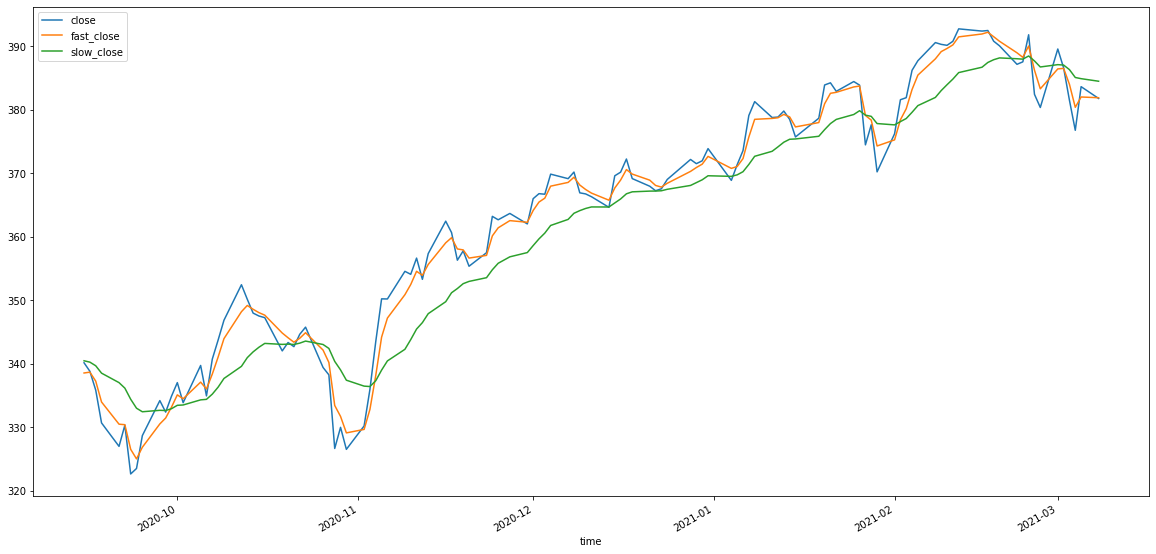

In [638]:
# Plot the EMA of closing prices
df[['close', 'fast_close', 'slow_close']].tail(120).plot(figsize=(20,10))

## Construct Signal on MACD

In [639]:
short_window = 12
long_window = 26
signal_window = 9

df['macd_short_window'] = df['close'].ewm(span=short_window,adjust=False).mean()
df['macd_long_window'] = df['close'].ewm(span=long_window,adjust=False).mean()
df['macd'] = df['macd_short_window'] - df['macd_long_window']
df['macd_signal'] = df['macd'].ewm(span=signal_window, adjust=False).mean()                      

df['macd_crossover_long'] = np.where(df['macd'] > df['macd_signal'],1.0,0.0)
df['macd_crossover_short'] = np.where(df['macd'] < df['macd_signal'],-1.0,0.0)
df['macd_crossover_signal'] = df['macd_crossover_long'] + df['macd_crossover_short']
#df.head()

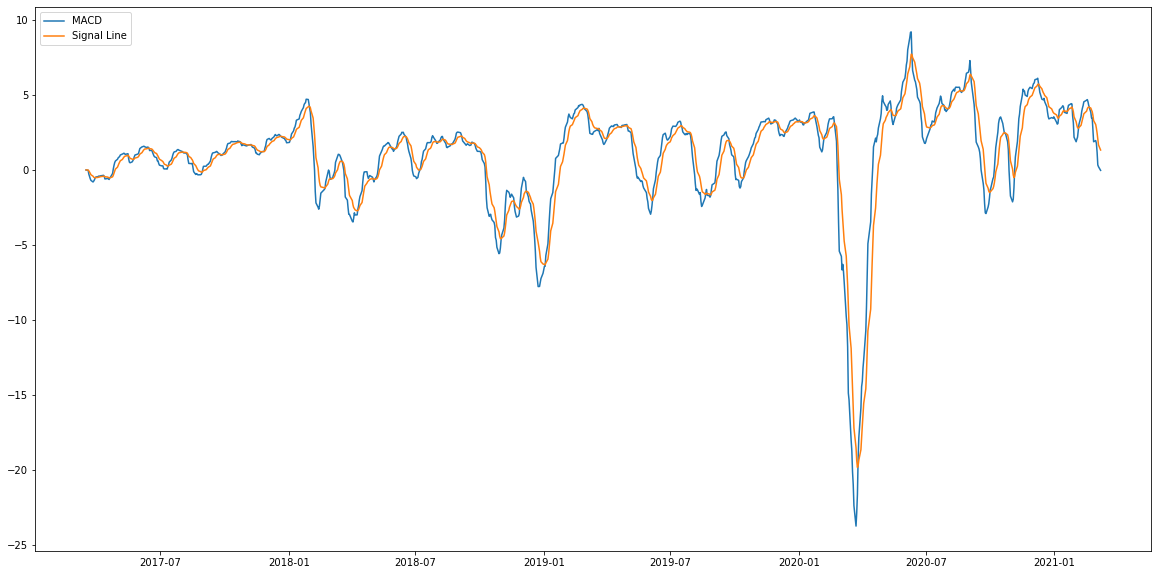

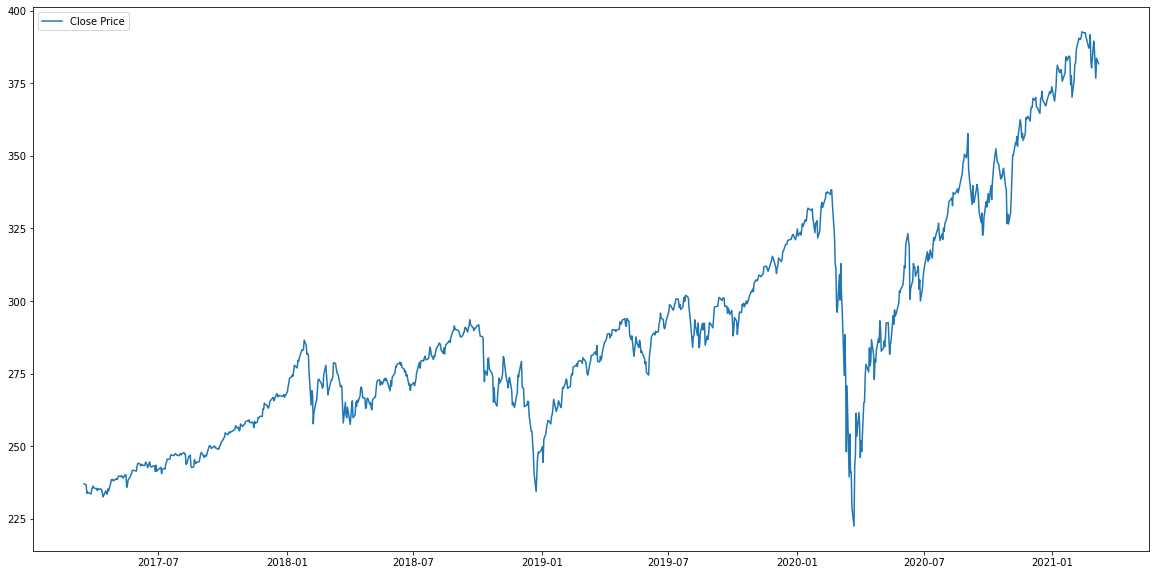

In [640]:
import matplotlib.pyplot as plt
#show macd and signal
plt.figure(figsize=(20,10))
plt.plot(df.index, df['macd'], label='MACD')
plt.plot(df.index, df['macd_signal'], label='Signal Line')
plt.legend(loc='upper left')
plt.show()

#show closing prices
plt.figure(figsize=(20,10))
plt.plot(df.index, df['close'], label='Close Price')
plt.legend(loc='upper left')
plt.show()

## Construct Signal on RSI

The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100. 

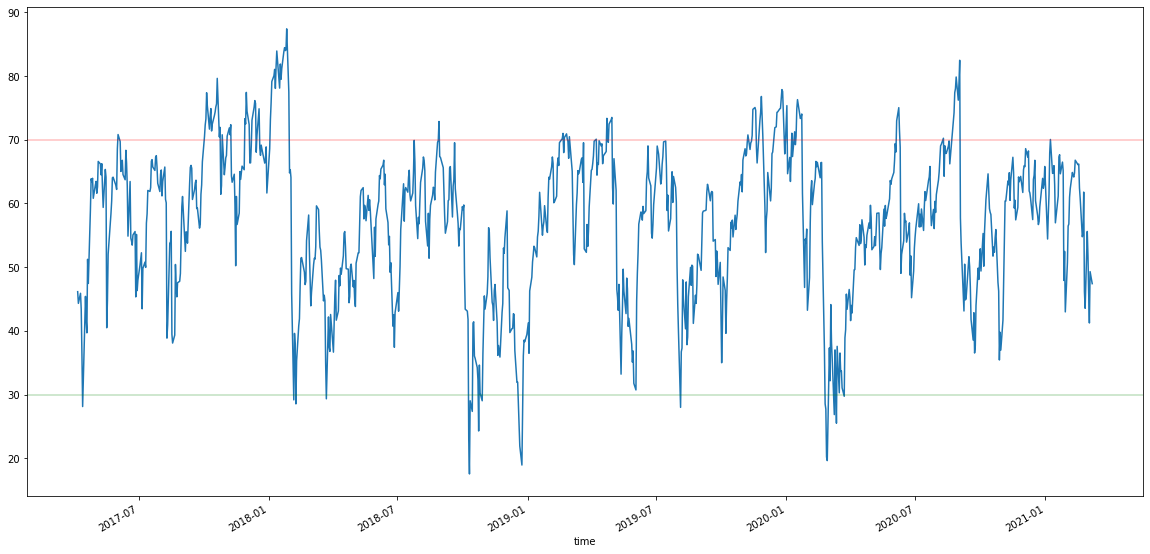

In [641]:
rsi_period = 14
chg = df['close'].diff(1)

gain = chg.copy()
loss = chg.copy()

gain[gain < 0] = 0
loss[loss > 0] = 0

avg_gain = gain.ewm(com=rsi_period-1,min_periods=rsi_period).mean()
avg_loss = loss.ewm(com=rsi_period-1,min_periods=rsi_period).mean()

rs = abs(avg_gain/avg_loss)
rsi = 100 - (100/(1+rs))

df['rsi'] = rsi
df['rsi'].plot(figsize=(20,10))
plt.axhline(y=30, color='g', alpha=.25) #oversold
plt.axhline(y=70, color='r',alpha=.25) #overbought

In [642]:
#rsi signal - live
df['rsi_long'] = np.where(
            (df['rsi'] > 30) & (df['rsi'] < 70),
        1.0,0.0)

df['rsi_short'] = np.where(
            (df['rsi'] > 70),
        -1.0,0.0)

df['rsi_signal'] = df['rsi_long'] + df['rsi_short']

## Construct EWM on Daily Returns Volatility

In [643]:
# Set short and long volatility windows
short_volatility_window = 1
long_volatility_window = 5

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
df['fast_volatility'] = df['daily_return'].ewm(halflife=short_volatility_window).std()
df['slow_volatility'] = df['daily_return'].ewm(halflife=long_volatility_window).std()

# Construct a crossover trading signal
df['volatility_trend_long'] = np.where(df['fast_volatility'] < df['slow_volatility'], 1.0, 0.0)
df['volatility_trend_short'] = np.where(df['fast_volatility'] > df['slow_volatility'], -1.0, 0.0) 
df['volatility_trend_signal'] = df['volatility_trend_long'] + df['volatility_trend_short']

In [644]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
df['bollinger_mid_band'] = df['close'].rolling(window=bollinger_window).mean()
df['bollinger_std'] = df['close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
df['bollinger_upper_band']  = df['bollinger_mid_band'] + (df['bollinger_std'] * 2)
df['bollinger_lower_band']  = df['bollinger_mid_band'] - (df['bollinger_std'] * 2)

# Calculate bollinger band trading signal
df['bollinger_long'] = np.where(df['close'] < df['bollinger_lower_band'], 1.0, np.nan)
df['bollinger_short'] = np.where(df['close'] > df['bollinger_upper_band'], -1.0, np.nan)

df['bollinger_long'] = np.where(df['close'] < df['bollinger_lower_band'], 1.0, 0.0)
df['bollinger_short'] = np.where(df['close'] > df['bollinger_upper_band'], -1.0, 0.0)

#df['bollinger_long'].fillna(1,method="ffill")
df['bollinger_long'].ffill(inplace=True)
df['bollinger_short'].ffill(inplace=True)

df.fillna(0.0,inplace=True)

df['bollinger_signal'] = df['bollinger_long'] + df['bollinger_short']

<AxesSubplot:xlabel='time'>

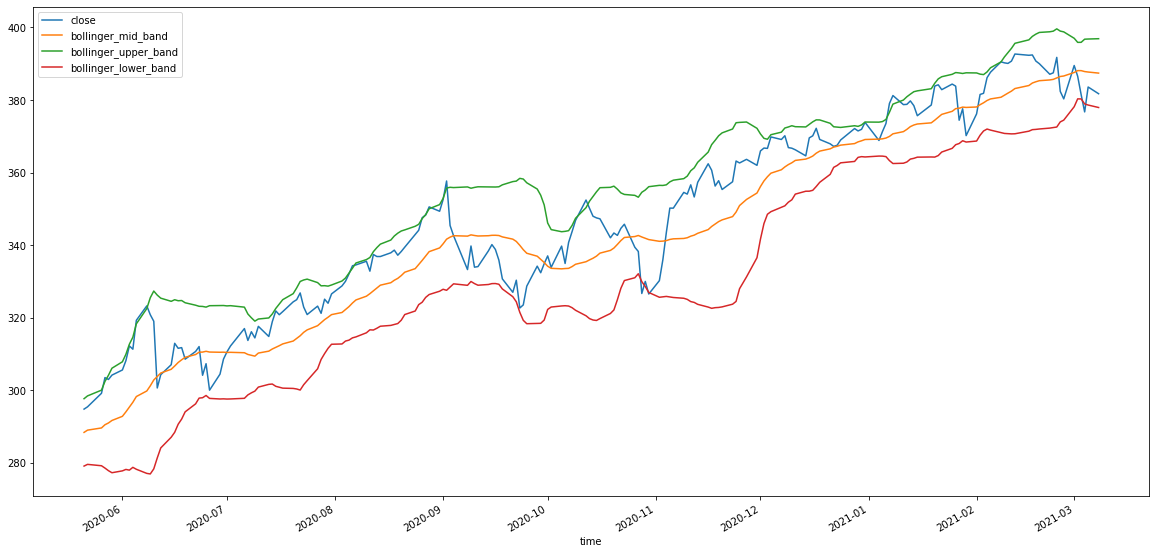

In [645]:
# Plot the Bollinger Bands for BTC/USD closing prices
df[['close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].tail(200).plot(figsize=(20,10))

#### Drop NAs and Calculate Daily Returns

In [646]:
df['daily_return'] = df['close'].dropna().pct_change()
#reset the index
df.reset_index(inplace=True)
#convert time to date
df['time'] = df['time'].dt.date

In [647]:
#df[['close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band', 'bollinger_signal']].head()

In [648]:
#export signals to csv
df.to_csv('trading_signals.csv')